In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
train_df = pd.read_csv('../../datasets/training_2nd_dataset.csv')

In [3]:
features = ['date_sequence', 'hour_sequence', 'avg_fbt_time', 'synack1_ratio', 'reset_ratio', 'tcp_conntime', 'icmp_lossrate', 'icmp_rtt',
            'ratio_499_5xx', 'inner_network_droprate', 'cpu_util', 'mem_util', 'io_await_avg', 'io_await_max', 'io_util_avg',
            'io_util_max', 'ng_traf_level']
domain_lst = ['domain_4','domain_6','domain_8','domain_10','domain_12','domain_16','domain_18','domain_20','all_domain']
col_lst = train_df.columns.to_list()

corrm = []
for i in domain_lst:
    if i == 'all_domain':
        df_tmp = train_df.copy()
    else:
        df_tmp = train_df[train_df['domain_name'] == i].copy()
    
    domain_corr = []
    for f in features:
        label_r = 'range' + str(col_lst.index(f))
        if f == 'date_sequence' or f == 'hour_sequence':
            a = df_tmp.groupby([f],as_index=False)[['buffer_rate']].mean()
            a.dropna(inplace=True)
        elif f == 'avg_fbt_time' or f == 'tcp_conntime' or f == 'icmp_rtt'or f == 'io_await_avg'or f == 'io_await_max':
            bin_wid = 1
            lst1 = [d*bin_wid for d in range(int(100/bin_wid)+1)]
            if max(df_tmp[f]) > 100:
                lst1.append(max(df_tmp[f])+1)
            else:
                lst1.append(100+1)
            df_tmp[label_r] = pd.cut(df_tmp[f],lst1,right=False,labels=lst1[:-1])
            a = df_tmp.groupby([label_r],as_index=False)[['buffer_rate']].mean()
            a.dropna(inplace=True)
            a = a.astype({label_r:float})
        else:
            bin_wid = 0.01
            df_tmp[label_r] = pd.cut(df_tmp[f], [d1*bin_wid for d1 in range(int(1/bin_wid)+2)], right=False,labels=[(0.5+d2)*bin_wid for d2 in range(int(1/bin_wid)+1)])
            a = df_tmp.groupby([label_r],as_index=False)[['buffer_rate']].mean()
            a.dropna(inplace=True)
            a = a.astype({label_r:float})
        domain_corr.append(a.corr(method='kendall').iloc[0,1])
    corrm.append(np.array(domain_corr))
corrm = np.array(corrm)
corrm

array([[ 0.85376344,  0.56521739,  0.56158416,  0.06658421,  0.33747412,
        -0.47524752,  0.24031008, -0.26376238,  0.2       , -0.78947368,
         0.63592622,  0.0406746 ,  0.25867861,  0.45267327, -0.07001718,
        -0.00484848,  0.37584158],
       [ 0.64301075,  0.44202899,  0.66019802,  0.00112045,  0.57852684,
        -0.18059406,  0.12070875,  0.75722772,  0.10294118,  0.23809524,
         0.92131286,  0.33506109, -0.17658228, -0.11722772, -0.05255614,
         0.06545455, -0.04990099],
       [ 0.81075269,  0.23188406,  0.73984745, -0.02460222,  0.02849389,
         0.21373737,  0.73549258,  0.67346939,  0.57874396,  0.5047619 ,
         0.84333127, -0.02405063,  0.35946249,  0.36910891, -0.32491819,
        -0.06424242,  0.0609901 ],
       [ 0.81505376,  0.53623188,  0.76540919, -0.07456588, -0.23888889,
         0.65333333,  0.72403983,  0.62828283,  0.54823529,  0.63636364,
         0.88291074, -0.22901235,  0.27324561,  0.2629703 ,  0.13200641,
         0.22424242

In [4]:
df_med = pd.DataFrame({'kendall_median': np.median(corrm, axis=0)},index=features)
df_med.sort_values(by=['kendall_median'],ascending=False, inplace=True)
df_med

,kendall_median
cpu_util,0.833024
date_sequence,0.815054
icmp_lossrate,0.724040
avg_fbt_time,0.645434
icmp_rtt,0.628283
ratio_499_5xx,0.548235
hour_sequence,0.478261
inner_network_droprate,0.457143
reset_ratio,0.305531
io_await_max,0.289901


In [5]:
# https://www.featureranking.com/tutorials/machine-learning-tutorials/information-gain-computation/
def compute_impurity(df, feature='buffer_rate', impurity_criterion='entropy'):
    """
    This function calculates impurity of a feature.
    Supported impurity criteria: 'entropy', 'gini'
    input: feature (this needs to be a Pandas series)
    output: feature impurity
    """
    df = df.copy()
    col_lst = df.columns.to_list()
    label_r = 'range' + str(col_lst.index(feature))
    bin_wid = 0.01
    df[label_r] = pd.cut(df[feature], [d1*bin_wid for d1 in range(int(1/bin_wid)+2)], right=False, labels=[(0.5+d2)*bin_wid for d2 in range(int(1/bin_wid)+1)])
#     a = df_tmp.groupby([label_r],as_index=False)[['buffer_rate']].mean()

    probs = df[label_r].value_counts(normalize=True)
    if impurity_criterion == 'entropy':
        impurity = -1 * np.sum(np.log2(probs) * probs)
    elif impurity_criterion == 'gini':
        impurity = 1 - np.sum(np.square(probs))
    else:
        raise ValueError('Unknown impurity criterion')
        
    return(round(impurity, 3))

In [6]:
def comp_feature_information_gain(df, target='buffer_rate', d_fea='domain_name', split_criterion='entropy'):
    """
    This function calculates information gain for splitting on 
    a particular descriptive feature for a given dataset
    and a given impurity criteria.
    Supported split criterion: 'entropy', 'gini'
    """
    df = df.copy()
    target_entropy = compute_impurity(df, target, split_criterion)
#     print("Original information:", target_entropy)

    entropy_list = list()
    weight_list = list()
    col_lst = df.columns.to_list()
    label_r = 'range' + str(col_lst.index(d_fea))
    if d_fea == 'date_sequence' or d_fea == 'hour_sequence'or d_fea == 'domain_name':
        descriptive_label = d_fea
    elif d_fea == 'avg_fbt_time' or d_fea == 'tcp_conntime' or d_fea == 'icmp_rtt'or d_fea == 'io_await_avg'or d_fea == 'io_await_max':
        bin_wid = 1
        lst1 = [d*bin_wid for d in range(int(100/bin_wid)+1)]
        if max(df[d_fea]) > 100:
            lst1.append(max(df[d_fea])+1)
        else:
            lst1.append(100+1)
        df[label_r] = pd.cut(df[d_fea],lst1,right=False,labels=lst1[:-1])
        descriptive_label = label_r
    else:
        bin_wid = 0.01
        df[label_r] = pd.cut(df[d_fea], [d1*bin_wid for d1 in range(int(1/bin_wid)+2)], right=False,labels=[(0.5+d2)*bin_wid for d2 in range(int(1/bin_wid)+1)])
        descriptive_label = label_r
        
    for level in df[descriptive_label].unique():
        df_feature_level = df[df[descriptive_label] == level]
        entropy_level = compute_impurity(df_feature_level, target, split_criterion)
        entropy_list.append(round(entropy_level, 3))
        weight_level = len(df_feature_level) / len(df)
        weight_list.append(round(weight_level, 3))

#     print('impurity of partitions:', entropy_list)
#     print('weights of partitions:', weight_list)

    feature_remaining_impurity = np.sum(np.array(entropy_list) * np.array(weight_list))
#     print('remaining impurity:', feature_remaining_impurity)
    
    information_gain = (target_entropy - feature_remaining_impurity) / target_entropy
    print('information gain:', round(information_gain, 4))
    
#     print('====================')

    return information_gain, entropy_list, weight_list, target_entropy

In [7]:
features = ['date_sequence', 'hour_sequence', 'avg_fbt_time', 'synack1_ratio', 'reset_ratio', 'tcp_conntime', 'icmp_lossrate', 'icmp_rtt',
            'ratio_499_5xx', 'inner_network_droprate', 'cpu_util', 'mem_util', 'io_await_avg', 'io_await_max', 'io_util_avg',
            'io_util_max', 'ng_traf_level']
domain_lst = ['domain_4','domain_6','domain_8','domain_10','domain_12','domain_16','domain_18','domain_20','all_domain']

ig = []
train_df = pd.read_csv('../../datasets/training_2nd_dataset.csv')
for d in domain_lst:
    if d == 'all_domain':
        df_tmp = train_df.copy()
    else:
        df_tmp = train_df[train_df['domain_name'] == d].copy()
    
    domain_ig = []
    for f in features:
        information_gain, _, _, _ = comp_feature_information_gain(df_tmp, target='buffer_rate', d_fea=f, split_criterion='entropy')
        domain_ig.append(round(information_gain,4))
    ig.append(np.array(domain_ig))
ig = np.array(ig)
df_ig = pd.DataFrame({'information_gain': np.median(ig,axis=0)},index=features)
df_ig.sort_values(by=['information_gain'],ascending=False, inplace=True)
df_ig

information gain: 0.0672
information gain: 0.0136
information gain: 0.0177
information gain: 0.0517
information gain: 0.0452
information gain: 0.0214
information gain: 0.0696
information gain: 0.0164
information gain: 0.0005
information gain: 0.0119
information gain: 0.0079
information gain: 0.0093
information gain: 0.0173
information gain: 0.0155
information gain: 0.0094
information gain: 0.009
information gain: 0.0093
information gain: 0.0138
information gain: 0.0156
information gain: 0.0225
information gain: 0.0504
information gain: 0.027
information gain: 0.0199
information gain: 0.0317
information gain: 0.0369
information gain: 0.0041
information gain: 0.0042
information gain: 0.0166
information gain: 0.0068
information gain: 0.0102
information gain: 0.0075
information gain: 0.0093
information gain: 0.0092
information gain: 0.0126
information gain: 0.0062
information gain: 0.0127
information gain: 0.0111
information gain: 0.0536
information gain: 0.0285
information gain: 0.0357
in

,information_gain
synack1_ratio,0.0517
icmp_lossrate,0.0382
reset_ratio,0.0285
tcp_conntime,0.0253
icmp_rtt,0.0237
avg_fbt_time,0.0137
hour_sequence,0.0124
io_await_max,0.0112
date_sequence,0.0109
ng_traf_level,0.0100


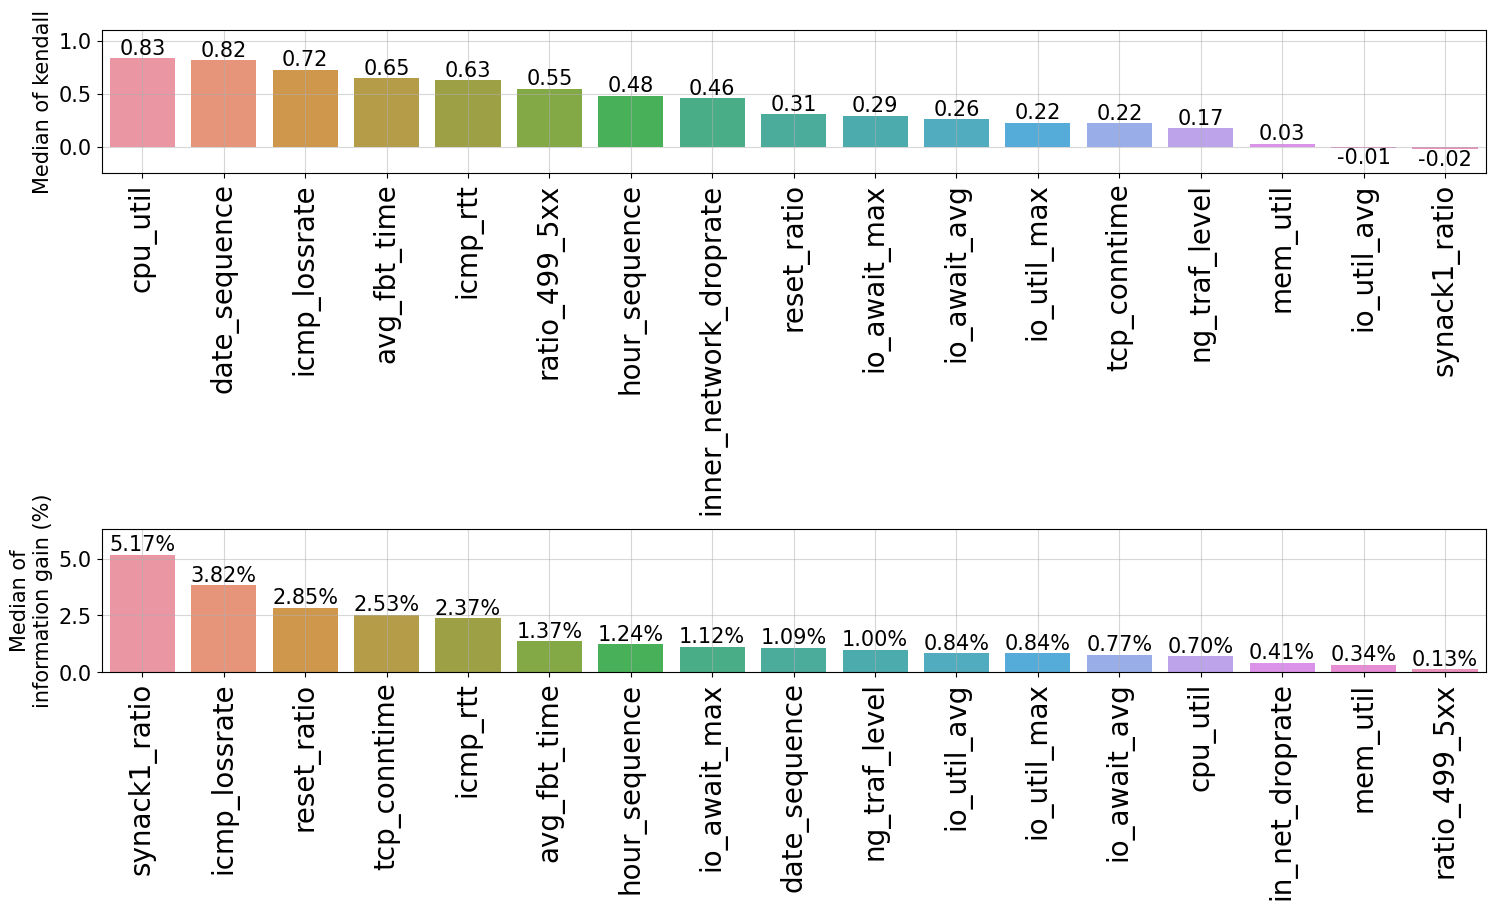

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi=100)
sns.set_palette("Paired")
# labels = app_uni.index.to_list()

A_as_ticklabel = [f"{a:.2f}" for a in df_med['kendall_median'].values]
labels1 = df_med.index.to_list()
ax1 = sns.barplot(x=labels1, y=df_med['kendall_median'].values, ax=axes[0])
ax1.grid(alpha=0.5)
# ax1.set_yticklabels(fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=15)
# ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax1.set_xticklabels(labels = labels1, rotation = 90, fontsize=20)
# ax1.set_yscale('log')
# ax1.set_xlabel('(a) The feature importance of LightGBM in the gerneral environment.' , fontsize=15)
ax1.set_ylabel('Median of kendall', fontsize=15)
ax1.bar_label(ax1.containers[0], label_type='edge', labels=A_as_ticklabel, fontsize=15)
ax1.set_ylim(top=1.1,bottom=-0.25)

# labels_2 = app_g_site.index.to_list()
A_as_ticklabel2 = [f"{a*100:.2f}%" for a in df_ig['information_gain'].values]
labels2 = df_ig.index.to_list()
labels2 = list(map(lambda x: x.replace('inner_network_droprate', 'in_net_droprate'), labels2))
ax2 = sns.barplot(x=labels2, y=df_ig['information_gain'].values*100, ax=axes[1])
ax2.grid(alpha=0.5)
# ax1.set_yticklabels(fontsize=11)
ax2.tick_params(axis='both', which='major', labelsize=15)
# ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax2.set_xticklabels(labels=labels2, rotation = 90, fontsize=20)
# ax1.set_yscale('log')
# ax1.set_xlabel('(a) The feature importance of LightGBM in the gerneral environment.' , fontsize=15)
ax2.set_ylabel('Median of\ninformation gain (%)', fontsize=15)
ax2.bar_label(ax2.containers[0], label_type='edge', labels=A_as_ticklabel2, fontsize=15)
ax2.set_ylim(top=6.3)

fig.tight_layout()
# fig.savefig('./data_relation.pdf')